## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [6]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [8]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [13]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [14]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [18]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [23]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 3)

0.462

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [25]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    scores.append((n, rmse))

In [26]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

In [27]:
df_scores

,n_estimators,rmse
0,10,0.461563
1,20,0.448184
2,30,0.445535
3,40,0.443637
4,50,0.442325
5,60,0.441639
6,70,0.441240
7,80,0.441125
8,90,0.440551
9,100,0.439973


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

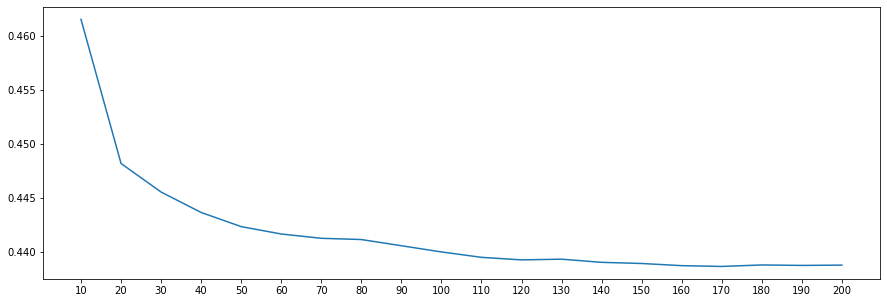

In [48]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.xticks(range(10, 201, 10))
plt.plot(df_scores.n_estimators, df_scores.rmse)

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [29]:
scores_1 = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        scores_1.append((d, n, rmse))

In [30]:
df_scores_1 = pd.DataFrame(scores_1, columns=['max_depth','n_estimators', 'rmse'])
df_scores_1

,max_depth,n_estimators,rmse
0,10,10,0.445553
1,10,20,0.442009
2,10,30,0.441381
3,10,40,0.441472
4,10,50,0.441067
...,...,...,...
75,25,160,0.438769
76,25,170,0.438696
77,25,180,0.438848
78,25,190,0.438702


What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

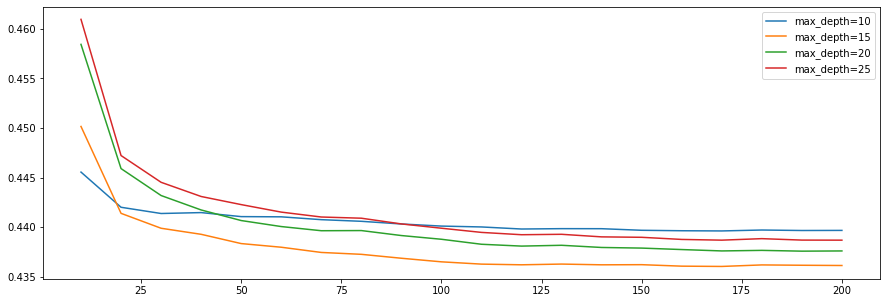

In [49]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores_1[df_scores_1.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()
plt.rcParams["figure.figsize"] = (15,5)

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [32]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [34]:
importances = rf.feature_importances_
importances

array([7.62639474e-02, 3.01019255e-02, 1.52775354e-01, 1.54100960e-01,
       5.32519176e-02, 2.64845849e-04, 9.65959537e-04, 3.40472718e-02,
       1.16609902e-03, 8.40278947e-05, 4.15942415e-02, 5.44303877e-02,
       3.91898194e-01, 4.03202776e-03, 5.02284130e-03])

<AxesSubplot:>

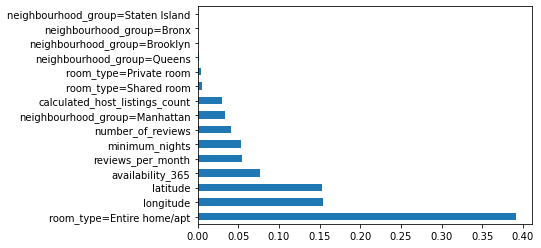

In [43]:
feat_importances = pd.Series(rf.feature_importances_, index=dv.get_feature_names())
feat_importances.nlargest(20).plot(kind='barh')

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [36]:
import xgboost as xgb
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [37]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

[0]	train-rmse:3.02752	val-rmse:3.02415
[1]	train-rmse:2.14667	val-rmse:2.14390
[2]	train-rmse:1.53878	val-rmse:1.53721
[3]	train-rmse:1.12557	val-rmse:1.12523
[4]	train-rmse:0.85100	val-rmse:0.85174
[5]	train-rmse:0.67490	val-rmse:0.67752
[6]	train-rmse:0.56687	val-rmse:0.57148
[7]	train-rmse:0.50448	val-rmse:0.51139
[8]	train-rmse:0.46913	val-rmse:0.47777
[9]	train-rmse:0.45009	val-rmse:0.45965
[10]	train-rmse:0.43912	val-rmse:0.44981
[11]	train-rmse:0.43327	val-rmse:0.44475
[12]	train-rmse:0.42936	val-rmse:0.44210
[13]	train-rmse:0.42668	val-rmse:0.44038
[14]	train-rmse:0.42463	val-rmse:0.43943
[15]	train-rmse:0.42259	val-rmse:0.43827
[16]	train-rmse:0.42113	val-rmse:0.43772
[17]	train-rmse:0.42074	val-rmse:0.43787
[18]	train-rmse:0.41896	val-rmse:0.43744
[19]	train-rmse:0.41812	val-rmse:0.43726
[20]	train-rmse:0.41716	val-rmse:0.43691
[21]	train-rmse:0.41499	val-rmse:0.43645
[22]	train-rmse:0.41437	val-rmse:0.43611
[23]	train-rmse:0.41403	val-rmse:0.43614
[24]	train-rmse:0.41391	va

0.43621034591295677

Now change `eta` first to `0.1` and then to `0.01`

In [38]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

[0]	train-rmse:3.87217	val-rmse:3.86889
[1]	train-rmse:3.49150	val-rmse:3.48840
[2]	train-rmse:3.14949	val-rmse:3.14635
[3]	train-rmse:2.84232	val-rmse:2.83951
[4]	train-rmse:2.56650	val-rmse:2.56412
[5]	train-rmse:2.31905	val-rmse:2.31692
[6]	train-rmse:2.09714	val-rmse:2.09526
[7]	train-rmse:1.89834	val-rmse:1.89663
[8]	train-rmse:1.72033	val-rmse:1.71878
[9]	train-rmse:1.56120	val-rmse:1.55976
[10]	train-rmse:1.41910	val-rmse:1.41786
[11]	train-rmse:1.29248	val-rmse:1.29149
[12]	train-rmse:1.17977	val-rmse:1.17907
[13]	train-rmse:1.07974	val-rmse:1.07936
[14]	train-rmse:0.99113	val-rmse:0.99118
[15]	train-rmse:0.91299	val-rmse:0.91348
[16]	train-rmse:0.84421	val-rmse:0.84524
[17]	train-rmse:0.78390	val-rmse:0.78525
[18]	train-rmse:0.73111	val-rmse:0.73308
[19]	train-rmse:0.68507	val-rmse:0.68776
[20]	train-rmse:0.64528	val-rmse:0.64883
[21]	train-rmse:0.61109	val-rmse:0.61518
[22]	train-rmse:0.58175	val-rmse:0.58648
[23]	train-rmse:0.55655	val-rmse:0.56186
[24]	train-rmse:0.53529	va

0.43249655247991464

In [39]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse

[0]	train-rmse:4.25336	val-rmse:4.25010
[1]	train-rmse:4.21141	val-rmse:4.20815
[2]	train-rmse:4.16988	val-rmse:4.16661
[3]	train-rmse:4.12877	val-rmse:4.12551
[4]	train-rmse:4.08807	val-rmse:4.08481
[5]	train-rmse:4.04779	val-rmse:4.04454
[6]	train-rmse:4.00792	val-rmse:4.00467
[7]	train-rmse:3.96845	val-rmse:3.96521
[8]	train-rmse:3.92937	val-rmse:3.92615
[9]	train-rmse:3.89070	val-rmse:3.88749
[10]	train-rmse:3.85242	val-rmse:3.84921
[11]	train-rmse:3.81452	val-rmse:3.81133
[12]	train-rmse:3.77701	val-rmse:3.77382
[13]	train-rmse:3.73988	val-rmse:3.73671
[14]	train-rmse:3.70313	val-rmse:3.69996
[15]	train-rmse:3.66674	val-rmse:3.66359
[16]	train-rmse:3.63073	val-rmse:3.62759
[17]	train-rmse:3.59508	val-rmse:3.59195
[18]	train-rmse:3.55979	val-rmse:3.55666
[19]	train-rmse:3.52487	val-rmse:3.52175
[20]	train-rmse:3.49030	val-rmse:3.48719
[21]	train-rmse:3.45608	val-rmse:3.45298
[22]	train-rmse:3.42220	val-rmse:3.41910
[23]	train-rmse:3.38867	val-rmse:3.38559
[24]	train-rmse:3.35548	va

1.630452438951798

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

